In [8]:
%load_ext autoreload
%autoreload 2

import torch

from sampling.sampling import sample_on_sphere_uniform, sample_conditional
from data.generation import SphereDecoderLinear, SphereDecoderIdentity
from data.encoder import SphereEncoder
import invertible_network_utils

import matplotlib.pyplot as plt

from evals.disentanglement import linear_disentanglement, permutation_disentanglement

import encoders

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


condition number threshold: 1.016459
layer 1/3,  condition number: 1.0129601754606334
layer 2/3,  condition number: 1.014109490117353
layer 3/3,  condition number: 1.0098830472256417
Maximum squared norm: tensor(1.0000, grad_fn=<MaxBackward1>)
Minimum squared norm: tensor(1.0000, grad_fn=<MinBackward1>)


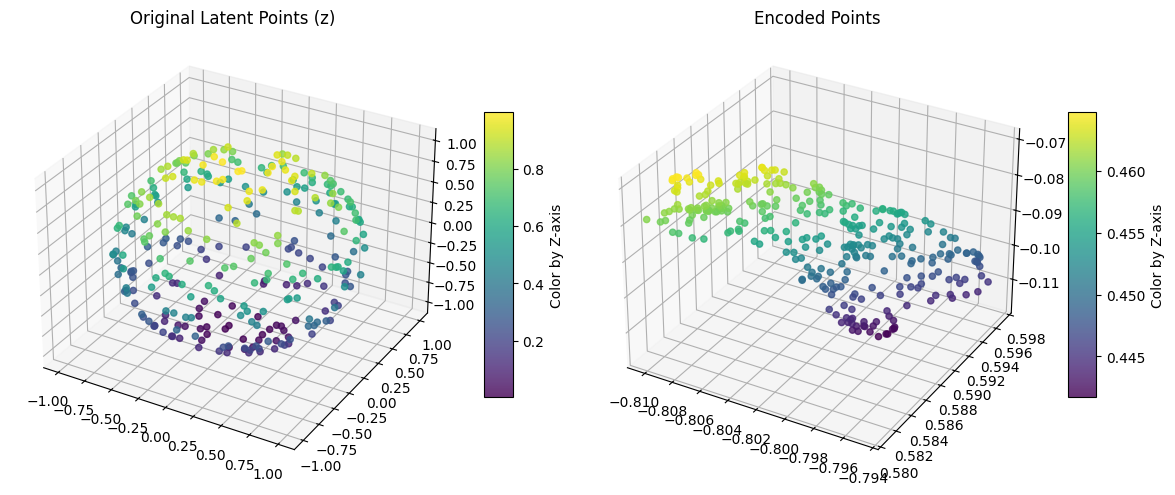

In [9]:
# Setting up the initial experiment

latent_dimension = 3
output_dimension = 3 # Here it must match, else it's not an invertible matrix
number_of_samples = 300

generation_process_linear = SphereDecoderLinear(latent_dimension, output_dimension)
generation_process_identity = SphereDecoderIdentity()

generation_process_mlp = invertible_network_utils.construct_invertible_mlp(
        n=3,
        n_layers=3,
        act_fct="leaky_relu",
        cond_thresh_ratio=0.0,
        n_iter_cond_thresh=25000,
).to('cpu')

encoder = SphereEncoder()

z_reference = sample_on_sphere_uniform(number_of_samples, latent_dimension)
decoded_data = generation_process_identity(z_reference)

encoded_data = encoder(decoded_data)

# Sanity checks
print('Maximum squared norm:', (encoded_data ** 2).sum(dim=1).max())
print('Minimum squared norm:', (encoded_data ** 2).sum(dim=1).min())

def visualize_spheres_side_by_side(original_latents, encoded_latents):
    z_3d = original_latents[:, :3].detach().numpy()
    encoded_data_3d = encoded_latents[:, :3].detach().numpy()
    
    c_original = 0.5 * z_3d[:, 2] + 0.5
    c_encoded = 0.5 * encoded_data_3d[:, 2] + 0.5

    fig = plt.figure(figsize=(12, 6))
    
    # Original points
    ax1 = fig.add_subplot(121, projection='3d')
    scatter1 = ax1.scatter(z_3d[:, 0], z_3d[:, 1], z_3d[:, 2], 
                            c=c_original, cmap='viridis', s=20, alpha=0.8)
    ax1.set_title('Original Latent Points (z)')
    fig.colorbar(scatter1, ax=ax1, shrink=0.5, aspect=10, label='Color by Z-axis')

    # Encoded points
    ax2 = fig.add_subplot(122, projection='3d')
    scatter2 = ax2.scatter(encoded_data_3d[:, 0], encoded_data_3d[:, 1], encoded_data_3d[:, 2], 
                            c=c_encoded, cmap='viridis', s=20, alpha=0.8)
    ax2.set_title('Encoded Points')
    fig.colorbar(scatter2, ax=ax2, shrink=0.5, aspect=10, label='Color by Z-axis')

    plt.tight_layout()
    plt.show()

visualize_spheres_side_by_side(z_reference, encoded_data)

Maximum squared norm (Original): 1.0000005960464478
Minimum squared norm (Original): 0.9999967217445374
Maximum squared norm (Encoded Augmented): 1.000000238418579
Minimum squared norm (Encoded Augmented): 0.9999997615814209


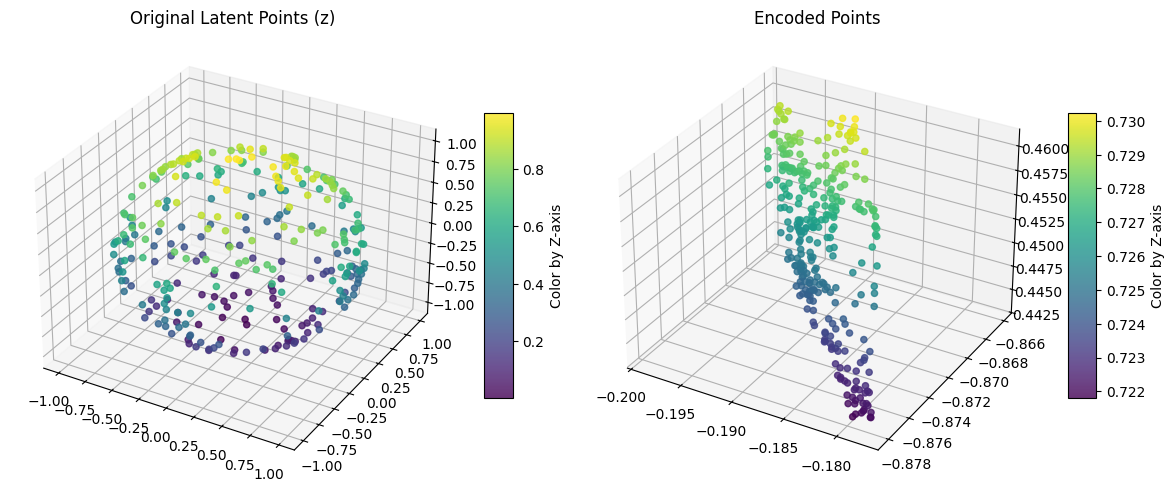

In [4]:
kappa_1 = 0.1
d_fixed = 0 # Initial experiment will allow variation in all dimensions

# Generate augmented latents (ensure `sample_conditional` is defined)
augmented_z = sample_conditional(z_reference, kappa_1, d_fixed)

decoded_augmented_data = generation_process_identity(augmented_z)

encoded_augmented_data = encoder(decoded_augmented_data)

# Sanity checks for augmented and encoded data
print('Maximum squared norm (Original):', (augmented_z ** 2).sum(dim=1).max().item())
print('Minimum squared norm (Original):', (augmented_z ** 2).sum(dim=1).min().item())
print('Maximum squared norm (Encoded Augmented):', (encoded_augmented_data ** 2).sum(dim=1).max().item())
print('Minimum squared norm (Encoded Augmented):', (encoded_augmented_data ** 2).sum(dim=1).min().item())

visualize_spheres_side_by_side(augmented_z, encoded_augmented_data)

## Training Optimal Encoder

In this part of the experiment you need to train an optimal encoder using the SimCLR framework. The goal is to get it to reconstruct a sphere in a setting where all dimensions are allowed to vary.

From the paper, they give the following recipie given $2N$ samples: $N$ original samples + $N$ augmentations:

1. $s_{i,j} := z_{i}^{T}z_{j} \ \forall i,j \in \{1,...,2N\}$ (Here we won't normalize, because the vecors are already on the unit sphere)
2. $l(i,j) := -log(\frac{exp(s_{i,j}/\tau)}{\Sigma_{k=1}^{2N} \mathbb{1}_{[k \neq i}]exp(s_{i,k}/\tau)})$
3. $\mathcal{L} := \frac{1}{2N} \Sigma_{k=1}^{N} l(2k-1,2k) + l(2k,2k-1)$

Here one thing I have omitted was that in their framework $z_{2k} \sim z_{2k-1}$

In this implementation we will use $z_{k} \sim z_{N + k}$

https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html

To get a similarity matrix of dot products of vectors, we can simply define $A := [z^{T}, \tilde{z}]^{T} \in \mathbb{R}^{2N \times 3}$ - a matrix that holds all vectors, and compute the resulting similarity matrix $S = AA^{T}$ using the matrix product.

$S_{i,j} = \Sigma_{k=1}^{3}A_{i,k}A^{T}_{k,j} = \Sigma_{k=1}^{3}A_{i,k}A_{j,k} = A_{i,1}A_{j,1} + A_{i,2}A_{j,2} + A_{i,3}A_{j,3} = z_{i,1}z_{j,1} + z_{i,2}z_{j,2} + z_{i,3}z_{j,3} = z_{i}^{T}z_{j}$

## On loss implementation

torch.nn.CrossEntropy for 1 sample takes in a vector of dimension $C$, and a class c, outputs $-log(\frac{exp(x_{c})}{\Sigma_{k=1}^{C}exp(x_{k})})$

What we need to do here is to first, mask the diagonal with $-\infty$, since we want the denominator to vanish out with exp(-inf) on the self-similarity term. On the numerator term, I want to take the indices in the following order: (2,1), (1,2), (3,4), (4,3), (5,6), (6,5), etc. (from the paper).

The implementation:

1. Compute similarity matrix
2. Mask the diagonal
3. Compute the labels by first doing arrange from 0,..,2N-1, then swap every 2 entries

**Correction:** Here we used a different convention than the SimCLR paper. Instead of marking 2k, 2k-1 samples as similar, we mark (k, N + k) samples as similar

Sequential(
  (0): Linear(in_features=3, out_features=30, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=30, out_features=150, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=150, out_features=150, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=150, out_features=150, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
  (8): Linear(in_features=150, out_features=150, bias=True)
  (9): LeakyReLU(negative_slope=0.01)
  (10): Linear(in_features=150, out_features=30, bias=True)
  (11): LeakyReLU(negative_slope=0.01)
  (12): Linear(in_features=30, out_features=3, bias=True)
  (13): RescaleLayer()
)
LOSS: 8.723362922668457 Linear: 0.584084689617157 Permutation: 0.635589338642766 Iterations:  1
LOSS: 8.721613883972168 Linear: 0.6696519255638123 Permutation: 0.7612105515251413 Iterations:  251
LOSS: 8.72197151184082 Linear: 0.664508044719696 Permutation: 0.7588347565427761 Iterations:  501
LOSS: 8.721946716308594 Li

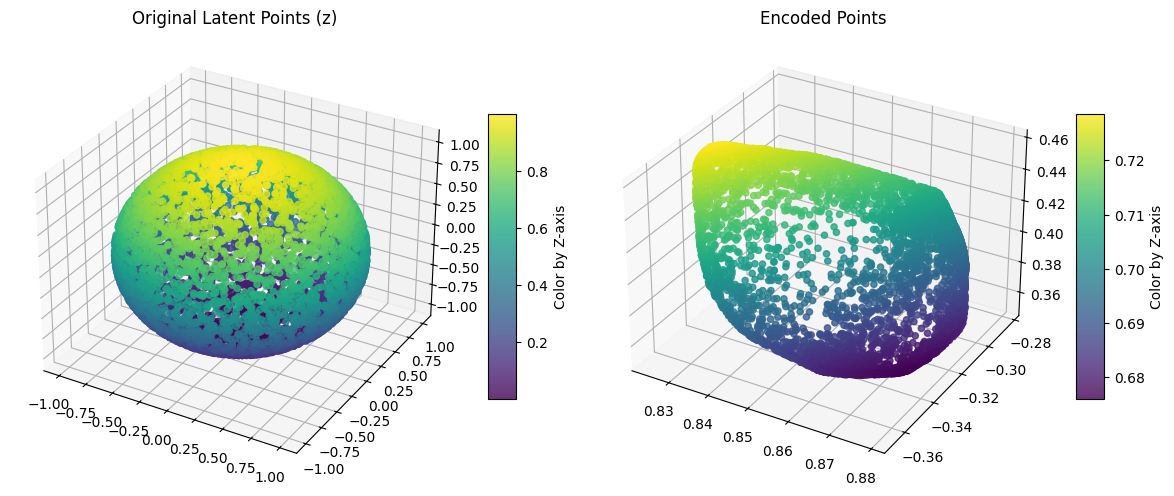

In [11]:
#Using SimCLR framework to find an optimal encoder

from simclr.simclr import SimCLRLoss

temperature = 0.1
iterations = 1000

loss_fn = SimCLRLoss(temperature)
encoder = encoders.get_mlp(
    n_in=3,
    n_out=3,
    layers=[
        3 * 10,
        3 * 50,
        3 * 50,
        3 * 50,
        3 * 50,
        3 * 10,
    ],
    output_normalization="fixed_sphere",
)
encoder = encoder.to("cpu")

# encoder.train()
optimizer = torch.optim.Adam(encoder.parameters(), lr=0.0001)

batch_size = 6144

# TODO: Use the same temperatrue when training

for i in range(iterations):  
    z = sample_on_sphere_uniform(batch_size, latent_dimension)
    z_augmented = sample_conditional(z, kappa_1, d_fixed)

    z_neg = sample_on_sphere_uniform(batch_size, latent_dimension)

    optimizer.zero_grad()
    
    x = generation_process_identity(z)
    x_augmented = generation_process_identity(z_augmented)
    x_neg = generation_process_identity(z_neg)
        
    z_reconstructed = encoder(x)
    z_rec_augmented = encoder(x_augmented)
    z_rec_neg = encoder(x_neg)
    
    l = loss_fn(z_reconstructed, z_rec_augmented, z_rec_neg)    
    l.backward()
    optimizer.step()

    if i % 250 == 0:
        linear_score = linear_disentanglement(z, z_reconstructed, mode="r2")[0][0]
        (perm_score, _, ), _ = permutation_disentanglement(z, z_reconstructed, mode="pearson",solver="munkres", rescaling=True)

        print('LOSS:', l.item(), 'Linear:', linear_score, 'Permutation:', perm_score, 'Iterations: ', i + 1)
        

encoder.eval()

test = sample_on_sphere_uniform(batch_size, latent_dimension)

x = generation_process_mlp(test)
result = encoder(x)

# print(result)

# Compare the reference latent samples with the encoded latent samples
visualize_spheres_side_by_side(test, result)